# LDA Model with Improved Parameters and Evaluation

In [1]:
import pandas as pd
import re
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from gensim.models import CoherenceModel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/oskardale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df0 = pd.read_csv('../0_data/statements.csv')
df1 = pd.read_csv('../0_data/eu_debate_transcripts_translated.csv')

In [3]:
df_chatgpt = df0[df0.provider == 'chatgpt']
df_deepseek = df0[df0.provider == 'deepseek']
documents_chatgpt = df_chatgpt.statement.values.tolist()
documents_deepseek = df_deepseek.statement.values.tolist()
documents_parliament = df1.translated_text.values.tolist()

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [5]:
def preprocess_text(documents):
    # Add domain-specific stopwords
    custom_stopwords = {'said', 'would', 'also', 'one', 'use'}
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    
    texts = []
    for doc in documents:
        doc = re.sub(r'[^a-zA-Z\s]', '', doc)
        tokens = word_tokenize(doc.lower())
        tokens = [lemmatizer.lemmatize(word) for word in tokens
                 if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
        texts.append(tokens)

    # Improve phrase detection
    bigram = Phrases(texts, min_count=3, threshold=50)
    trigram = Phrases(bigram[texts], min_count=3, threshold=50)
    
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    return texts


In [6]:
texts = {
    'chatgpt': preprocess_text(documents_chatgpt),
    'deepseek': preprocess_text(documents_deepseek),
    'parliament': preprocess_text(documents_parliament)
}

In [7]:
def train_lda(texts, num_topics=4, passes=30, chunksize=2000):
    dictionary = corpora.Dictionary(texts)
    # Adjust dictionary filtering
    dictionary.filter_extremes(no_below=3, no_above=0.7)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Try different alpha/beta combinations
    alphas = [0.01, 0.1, 'symmetric']
    betas = [0.01, 0.1]
    best_model = None
    best_coherence = -1
    
    for alpha in alphas:
        for beta in betas:
            lda_model = LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=num_topics,
                random_state=42,
                passes=passes,
                alpha=alpha,
                eta=beta,
                chunksize=chunksize,
                minimum_probability=0.01
            )
            
            # Evaluate coherence
            coherence_model = CoherenceModel(
                model=lda_model,
                texts=texts,
                dictionary=dictionary,
                coherence='c_v'
            )
            coherence_score = coherence_model.get_coherence()
            
            if coherence_score > best_coherence:
                best_coherence = coherence_score
                best_model = lda_model
                
    return {
        'model': best_model,
        'dict': dictionary,
        'corpus': corpus,
        'coherence': best_coherence
    }


In [8]:
def compute_coherence_values(texts, dictionary, corpus, start=2, end=8, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, end, step):
        model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        random_state=42,
                        passes=15,
                        alpha='auto',
                        eta='auto')
        model_list.append(model)
        coherence_model = CoherenceModel(model=model,
                                       texts=texts,
                                       dictionary=dictionary,
                                       coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

In [9]:
def evaluate_model(model, texts, dictionary, corpus):
    # Coherence score
    coherence_model = CoherenceModel(
        model=model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    
    # Perplexity
    perplexity = model.log_perplexity(corpus)
    
    # Topic diversity (unique words in top N words per topic)
    n_top_words = 20
    topics = model.show_topics(num_topics=-1, num_words=n_top_words, formatted=False)
    unique_words = set()
    for topic in topics:
        unique_words.update([word for word, _ in topic[1]])
    topic_diversity = len(unique_words) / (n_top_words * model.num_topics)
    
    return {
        'coherence': coherence_score,
        'perplexity': perplexity,
        'topic_diversity': topic_diversity
    }


In [10]:
# Train and evaluate models with new parameters
models = {}
for name, text in texts.items():
    print(f"\nProcessing {name} dataset...")
    
    # Find optimal number of topics
    dictionary = corpora.Dictionary(text)
    dictionary.filter_extremes(no_below=3, no_above=0.7)
    corpus = [dictionary.doc2bow(doc) for doc in text]
    
    model_list, coherence_values = compute_coherence_values(
        text, dictionary, corpus, start=2, end=12, step=2
    )
    optimal_num_topics = range(2, 12, 2)[coherence_values.index(max(coherence_values))]
    print(f"Optimal number of topics: {optimal_num_topics}")
    
    # Train model with optimal parameters
    models[name] = train_lda(text, num_topics=optimal_num_topics)
    
    # Evaluate model
    metrics = evaluate_model(
        models[name]['model'],
        text,
        models[name]['dict'],
        models[name]['corpus']
    )
    print(f"Evaluation metrics for {name}:")
    print(f"Coherence: {metrics['coherence']:.4f}")
    print(f"Perplexity: {metrics['perplexity']:.4f}")
    print(f"Topic Diversity: {metrics['topic_diversity']:.4f}")


Processing chatgpt dataset...
Optimal number of topics: 6
Evaluation metrics for chatgpt:
Coherence: 0.2537
Perplexity: -6.4714
Topic Diversity: 0.3667

Processing deepseek dataset...
Optimal number of topics: 4
Evaluation metrics for deepseek:
Coherence: 0.3566
Perplexity: -5.8131
Topic Diversity: 0.6000

Processing parliament dataset...
Optimal number of topics: 2
Evaluation metrics for parliament:
Coherence: 0.3196
Perplexity: -7.2861
Topic Diversity: 0.7500



Model: chatgpt


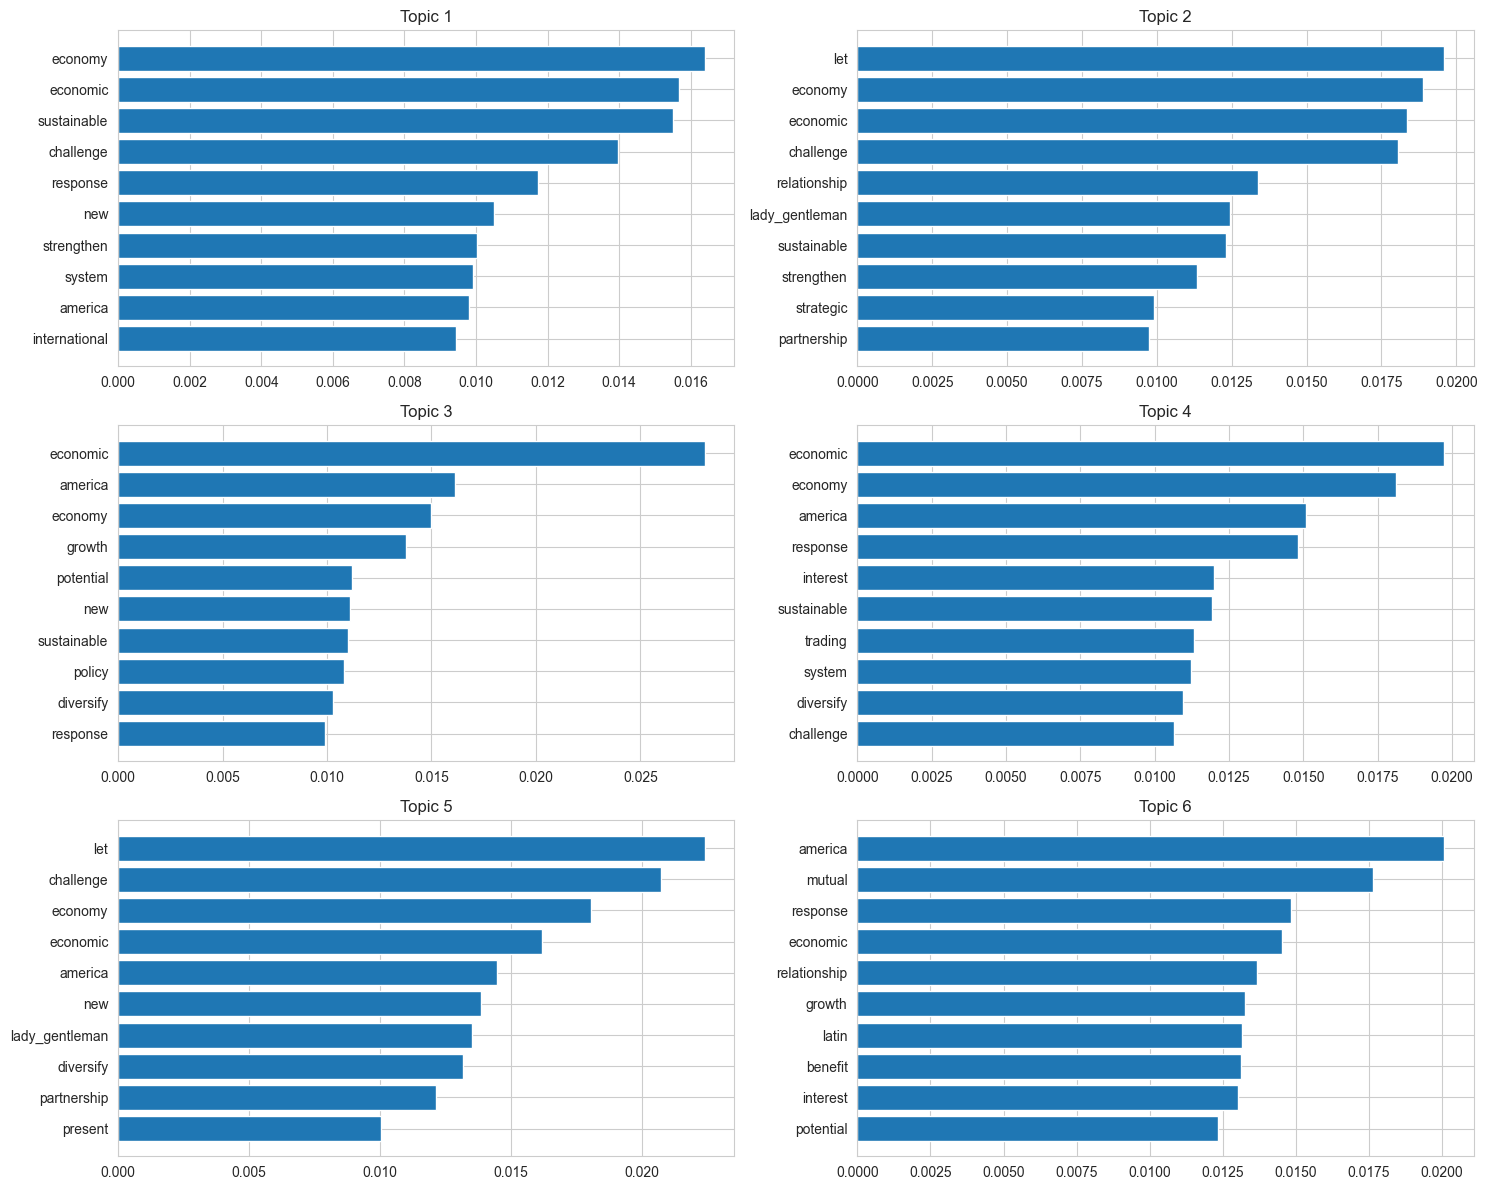


Model: deepseek


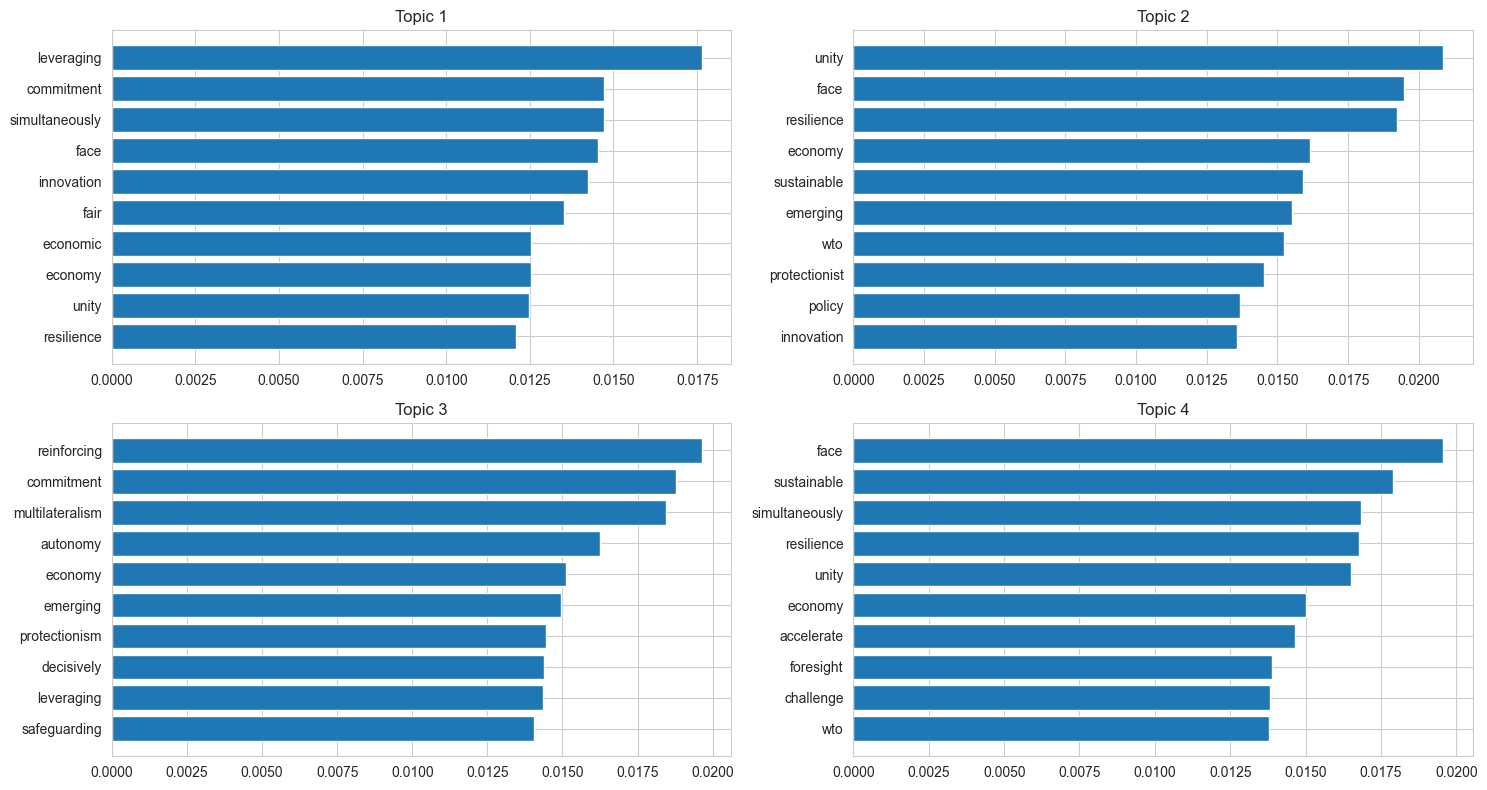


Model: parliament


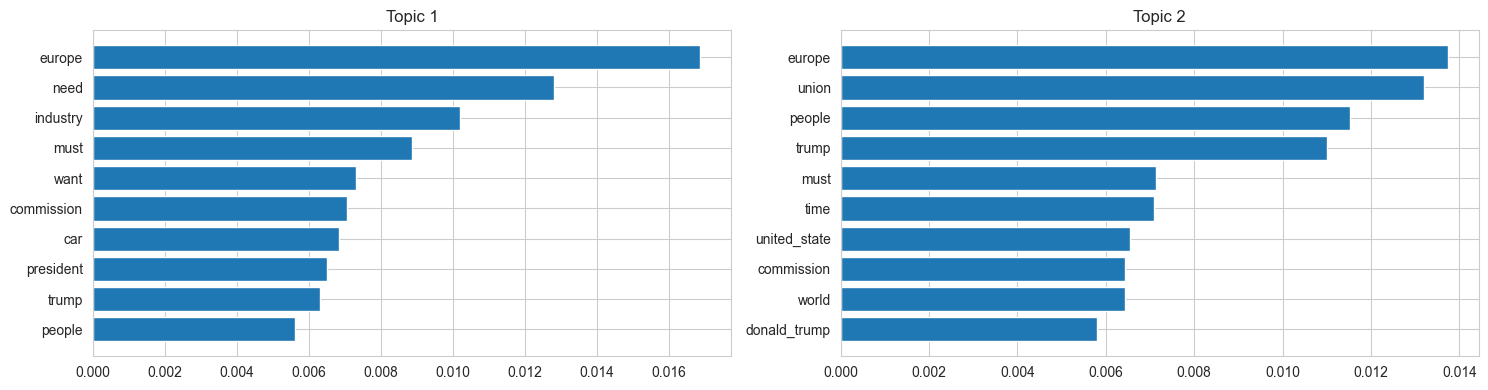

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_lda_topics(lda_model, dictionary, num_words=10):

    fig, axes = plt.subplots(int(np.ceil(lda_model.num_topics/2)), 2,
                            figsize=(15, 4*int(np.ceil(lda_model.num_topics/2))))
    axes = axes.flatten()

    for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words, num_topics=-1):
        top_words = [w[0] for w in topic]
        top_probs = [w[1] for w in topic]

        axes[idx].barh(top_words, top_probs)
        axes[idx].set_title(f'Topic {idx+1}')
        axes[idx].invert_yaxis()

    plt.tight_layout()
    return fig

for name, _ in texts.items():
    print(f"\nModel: {name}")
    vis = visualize_lda_topics(models[name]['model'], models[name]['dict'], num_words=10)
    plt.show()